In [1643]:
import pandas as pd
import os
import tweepy as tw
import pandas as pd
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from requests import request
import re
from collections import Counter
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
import demoji
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder, TrigramAssocMeasures
from operator import itemgetter
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
from gensim import models
import gensim.corpora as corpora
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize, pos_tag
import networkx as nx
import json

In [668]:
consumer_key= 'hw44QrPJFs1iqKlUx0pPXIasy'
consumer_secret= 'eQ8r2GoyTzjf9HnQVLtuEvZrKHnk5RqWvoV7ePDwbrGpRTEM2d'
access_token= '1251926676780564483-zsqauIKp86GjCFOMw9PHHrb2a1tvpb'
access_token_secret= '4oeNjtN4PLIPRrMviuMlY7xCD9k3s7TQMLWifDuISgwKY'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True)

In [ ]:
df = pd.read_csv("./data/tweets.csv")

In [ ]:
print("Number of distinct users:", df.user_id.nunique(),
      "\nNumber of total tweets:", df.id.nunique(),
     "\nNumber of distinct tweets:", df.text.nunique(),
     "\nNumber of retweets:", len(df.loc[df.text.str.startswith("RT")]),
     "\nNumber of distinct retweets:", df.loc[df.text.str.startswith("RT"), "text"].nunique(),
     "\nNumber of distinct original tweets:", df.loc[~df.text.str.startswith("RT"), "text"].nunique())

## Retrieve full text of retweets

In [ ]:
def get_full_text(value):
    status = api.get_status(value, tweet_mode="extended")
    try:
        return status.retweeted_status.full_text
    except AttributeError:  # Not a Retweet
        print("not a retweet")
        

In [ ]:
df["original_tweet"] = None

In [ ]:
for n, text in enumerate(df.loc[df.text.str.startswith("RT"), "text"].unique()):
    value = df.loc[df.text == text, "id"].values[0]
    try:
        original = get_full_text(value)
        df.loc[df.text == text, "original_tweet"] = original
    except:
        continue

In [ ]:
df.to_csv("./data/tweets_complete.csv", index=False)

## Retrieve hashtags

In [ ]:
df = pd.read_csv("./data/tweets_complete.csv")
df.loc[df.original_tweet.isnull(), "original_tweet"] = None

In [1486]:
def get_hashtags(tweet_id):
    original = df.loc[df.id == tweet_id, "original_tweet"].values[0]
    try:
        found = re.findall("#[a-zA-Z]+", original)
    except:
        found = re.findall("#[a-zA-Z]+", df.loc[df.id == tweet_id, "text"].values[0])
    return found

In [1487]:
df["hashtags"] = None
df["hashtags"] = df["hashtags"].astype('object')

for i in df.index:
    tweet_id = df.loc[i,"id"]
    try:
        lst = get_hashtags(tweet_id)
        df.set_value(i, "hashtags", get_hashtags(tweet_id))
    except Exception as e:
        print(e)
        continue


c:\users\antonella\desktop\antonella\magistrale\2_anno\tirocinio\nlp\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


# Retrieve Emoji

In [ ]:
demoji.download_codes()
def get_emoji(tweet_id):
    original = df.loc[df.id == tweet_id, "original_tweet"].values[0]
    if original:
        text = original
    else:
        text = df.loc[df.id == tweet_id, "text"].values[0]
    found = list(demoji.findall(text).keys())
    
    #print(found)

    return found


In [ ]:
df["emojis"] = None
df["emojis"] = df["emojis"].astype('object')

for i in df.index:
    tweet_id = df.loc[i,"id"]
    try:
        df.set_value(i, "emojis", get_emoji(tweet_id))
    except Exception as e:
        print(e)
        continue

## Exploration

### Most retweeted tweet

In [1449]:
#Most retweeted
print(pd.DataFrame(df.loc[df.text.str.startswith("RT")].original_tweet.value_counts()).reset_index().loc[0, "index"])
print("\nRetweeted", 
      pd.DataFrame(df.loc[df.text.str.startswith("RT")].original_tweet.value_counts()).reset_index().loc[0, "original_tweet"],
     "times")


#AOC, If we put your brain on the edge of a razor blade, it would look like a B-B rollin' down a four-lane highway. 
@JennaEllisEsq 
@realDonaldTrump 
@RichardGrenell 
@DonaldJTrumpJr 
@BarbaraRedgate 
@molmccann 
@abigailcfrye 
@atensnut 
@TheLastRefuge2 https://t.co/J3tSe51DJ2

Retweeted 1132 times


### Most used hashtags

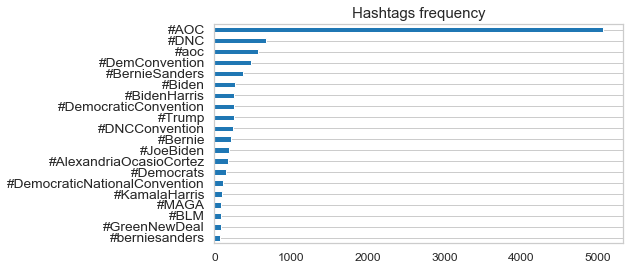

In [1559]:
all_hashtags = [item for sublist in df.drop_duplicates("text").hashtags if sublist for item in sublist]

letter_counts = Counter(all_hashtags)
df_hash = pd.DataFrame.from_dict(letter_counts, orient='index').rename({"index":"hashtag", 0:"count"}, axis=1).sort_values("count", ascending=False)[:20].sort_values("count", ascending=True)

df_hash.plot(kind='barh',title="Hashtags frequency", legend=False, figsize=(9,4))
plt.xticks(size=12)
plt.tight_layout()
plt.savefig("./figures/hashtags.png")
plt.gca().xaxis.grid(False)
plt.show()


### Most active users

In [1451]:
pd.DataFrame(df.user_screen_name.value_counts()).head(5)

,user_screen_name
ShaneCarruth,49
ec0anarch0,41
10WallStreet,38
KidBrightwillow,36
TheBethofDeath,35


### Most followed user

In [2283]:
df.sort_values("friends_count", ascending=False)[["username", "friends_count"]].head(5)

,username,friends_count
13670,Jeffrey Levin,516521
19113,#ismyhairmessedup,444543
9847,Ryan Fournier,308568
11201,Ricky Davila,193599
10774,QT@Anon 🌟🌟🌟,189211


In [2284]:
df.drop_duplicates("text").sort_values("retweet_count", ascending=False)[["original_tweet", "retweet_count"]].head(5)

,original_tweet,retweet_count
14824,"Rep @AOC: ""I do not need Rep. Yoho to apologiz...",85306
15367,queen shit 👑 @AOC https://t.co/XaH24dsNVx,51575
9471,"Rep. Ocasio-Cortez: ""Mr. Yoho mentioned that h...",41849
14630,Ivanka says AOC doesn’t understand the America...,35665
2179,#AOC was right! This heartbreaking video of st...,31988


## Clean text

In [1638]:
stops = stopwords.words('english')
def cleaning(text):
    lemmatizer = WordNetLemmatizer() 
    text = demoji.replace(text, "")
    text = re.sub(r'https\S+', '', text, flags=re.MULTILINE)
    text = re.sub("&amp;", "and", text)
    text = re.sub(r'@\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\S+', '', text, flags=re.MULTILINE)
    text = re.sub("[^a-zA-Z]+", " ", text.lower()) 
    

    text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ") if word not in stops])
    ret = re.sub(" +", " ", text)
    return ret

In [1639]:
df["clean_text"] = None

df.loc[df["original_tweet"].isnull(), "original_tweet"]= None

for n, tweet_id in enumerate(df.id):
    original = df.loc[df.id == tweet_id, "original_tweet"].values[0]
    if original:
        text = original
    else:
        text = df.loc[df.id == tweet_id, "text"].values[0]
        
    df.loc[df.id == tweet_id, "clean_text"] = cleaning(text)

## Assign Sentiment

La sentiment analysis non è stata inclusa nel report perché una rapida ispezione manuale dell'assengazione del sentiment ha rivelato poca accuratezza.

In [2276]:
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score["compound"]

def get_sentiment(text):
    score = sentiment_analyzer_scores(text)
    if score < 0:
        return "neg"
    if score >= 0 and score < 0.3:
        return "neu"
    else:
        return "pos"

In [2277]:
df["sentiment"] = None

for n, tweet_id in enumerate(df.id):
    text = df.loc[df.id == tweet_id, "clean_text"].values[0]
    df.loc[df.id == tweet_id, "sentiment"] = get_sentiment(text)


In [2280]:
df.drop_duplicates("clean_text").sentiment.value_counts()

pos    4417
neg    4182
neu    3748
Name: sentiment, dtype: int64

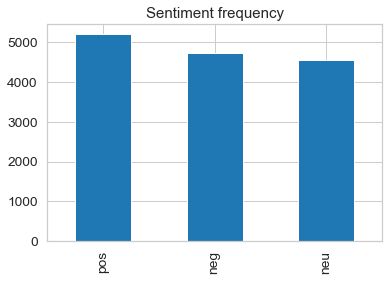

In [2285]:
df.drop_duplicates("text").sentiment.value_counts().plot(kind='bar', title="Sentiment frequency", legend=False)
plt.show()

In [ ]:
df.drop_duplicates("text").sentiment.value_counts()

In [ ]:
neg_tweets = df.drop_duplicates("text").loc[df.sentiment == "neg", "clean_text"]
neg_corpus = " ".join([item for item in neg_tweets]).split()

neg_counts = Counter(neg_corpus)
neg_df = pd.DataFrame.from_dict(neg_counts, orient='index').rename({"index":"word", 0:"count"}, axis=1).sort_values("count", ascending=False)[1:50]

neg_df.plot(kind='barh', figsize=(16,9), title="Negative words frequency", legend=False)
plt.show()


## Wordcloud

#### Single words

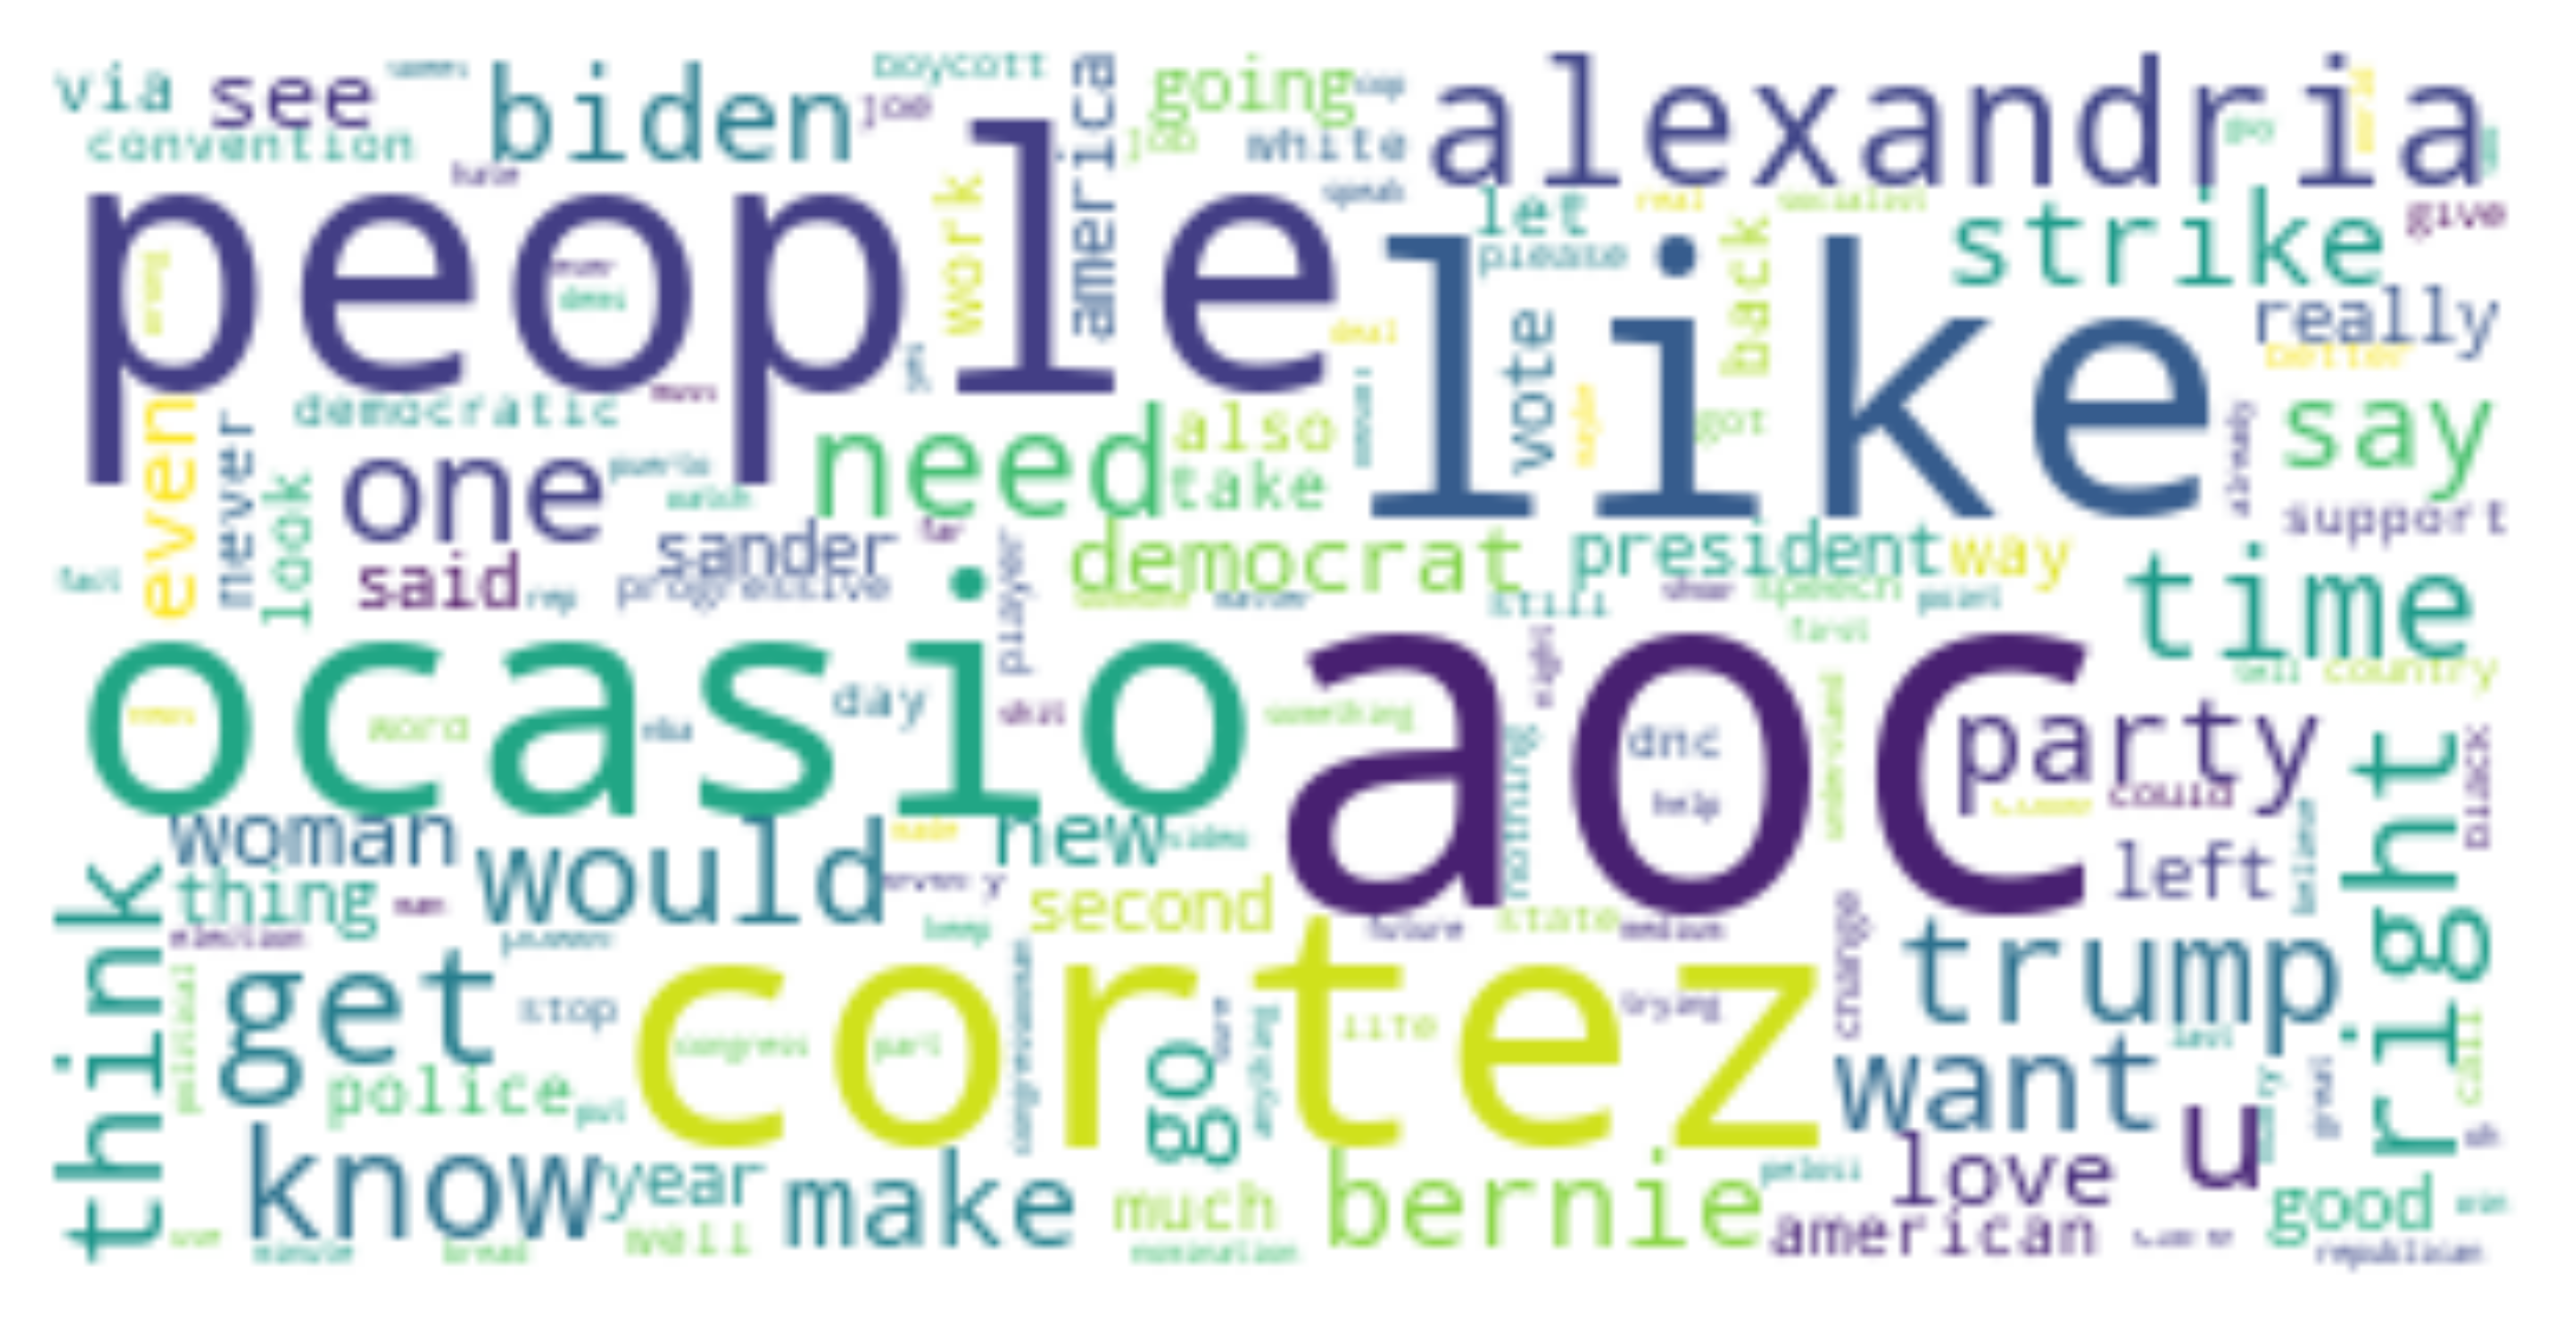

In [2292]:
#from PIL import Image
# Join the different processed titles together.
plt.figure(figsize=(7,7), dpi=500)
long_string = ' '.join(list(df['clean_text'].dropna().unique()))
# Create a WordCloud object
mask = np.array(Image.open("aoc_image_or.png"))

wordcloud = WordCloud(background_color="white", max_words=150, contour_width=1,
                     width=300,height=150)  #mask=mask,max_font_size=90, colormap="hot", contour_color='white')
# Generate a word cloud
w = wordcloud.generate_from_frequencies(Counter([w.strip() for w in long_string.split(" ")]))
# Visualize the word cloud
plt.imshow(w, interpolation="bilinear")
plt.axis("Off")
plt.show()

In [2290]:
long_string = ' '.join(list(df['clean_text'].dropna().unique()))
#Counter([w.strip() for w in long_string.split(" ") if w])


## Bigrams

In [1680]:
tokens = nltk.word_tokenize(long_string)
text = nltk.Text(tokens)
 
# Load default stop words and add a few more.
 
# Remove extra chars and remove stop words.
text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text]
text_content = [word for word in text_content if word not in stops]
 
# After the punctuation above is removed it still leaves empty entries in the list.
# Remove any entries where the len is zero.
text_content = [s for s in text_content if len(s) != 0]
 
# Best to get the lemmas of each word to reduce the number of similar words
# on the word cloud. The default lemmatize method is noun, but this could be
# expanded.
# ex: The lemma of 'characters' is 'character'.
text_content = [WordNetLemmatizer().lemmatize(t) for t in text_content]
 
# setup and score the bigrams using the raw frequency.
finder = BigramCollocationFinder.from_words(text_content)
bigram_measures = BigramAssocMeasures()
scored = finder.score_ngrams(bigram_measures.likelihood_ratio)
 
# By default finder.score_ngrams is sorted, however don't rely on this default behavior.
# Sort highest to lowest based on the score.
scoredList = sorted(scored, key=itemgetter(1), reverse=True)
 
# word_dict is the dictionary we'll use for the word cloud.
# Load dictionary with the FOR loop below.
# The dictionary will look like this with the bigram and the score from above.
# word_dict = {'bigram A': 0.000697411,
#             'bigram B': 0.000524882}
 
word_dict = {}
 
listLen = len(scoredList)
 
# Get the bigram and make a contiguous string for the dictionary key. 
# Set the key to the scored value. 
for i in range(listLen):
    word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]


In [2163]:
tokens = nltk.word_tokenize(long_string)
text = nltk.Text(tokens)
 
# Load default stop words and add a few more.
 
# Remove extra chars and remove stop words.
text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text]
text_content = [word for word in text_content if word not in stops]
 
# After the punctuation above is removed it still leaves empty entries in the list.
# Remove any entries where the len is zero.
text_content = [s for s in text_content if len(s) != 0]
 
# Best to get the lemmas of each word to reduce the number of similar words
# on the word cloud. The default lemmatize method is noun, but this could be
# expanded.
# ex: The lemma of 'characters' is 'character'.
text_content = [WordNetLemmatizer().lemmatize(t) for t in text_content]
 
# setup and score the bigrams using the raw frequency.
finder = TrigramCollocationFinder.from_words(text_content)
trigram_measures = TrigramAssocMeasures()
scored = finder.score_ngrams(trigram_measures.likelihood_ratio)
 
# By default finder.score_ngrams is sorted, however don't rely on this default behavior.
# Sort highest to lowest based on the score.
scoredList_tr = sorted(scored, key=itemgetter(1), reverse=True)
 
# word_dict is the dictionary we'll use for the word cloud.
# Load dictionary with the FOR loop below.
# The dictionary will look like this with the bigram and the score from above.
# word_dict = {'bigram A': 0.000697411,
#             'bigram B': 0.000524882}
 
word_dict_tr = {}
 
listLen = len(scoredList_tr)
 
# Get the bigram and make a contiguous string for the dictionary key. 
# Set the key to the scored value. 
for i in range(listLen):
    word_dict_tr['_'.join(scoredList_tr[i][0])] = scoredList_tr[i][1]



In [ ]:
# Set word cloud params and instantiate the word cloud.
# The height and width only affect the output image file.
WC_max_words = 100
 
wordCloud = WordCloud(background_color="white", max_words=WC_max_words, width=600,height=400)
 
wordCloud.generate_from_frequencies(word_dict)
wordCloud.to_image()

## LDA

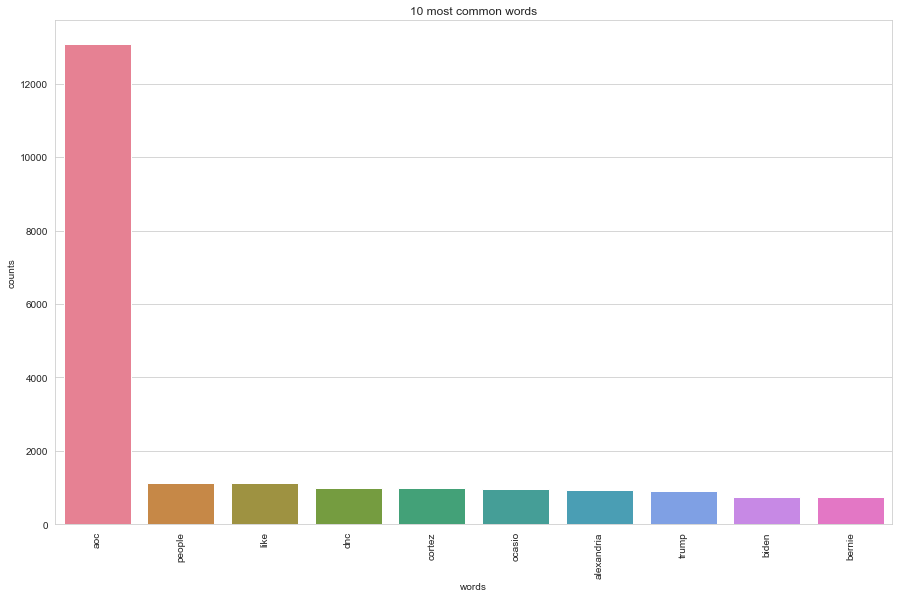

In [242]:
# Load the library with the CountVectorizer method

sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['clean_text'].dropna().unique())
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [245]:
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 3
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
aoc dnc biden bernie berniesanders joebiden demconvention trump sander democrat

Topic #1:
aoc people like right need think want say trump time

Topic #2:
aoc cortez ocasio alexandria strike boycott player know nba job


In [ ]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'w') as f:
            pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

In [ ]:
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')


In [102]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    is_adj = lambda pos: pos[:2] == 'JJ'

    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos) or is_adj(pos)]
    return ' '.join(all_nouns)

In [173]:
def is_nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[0][1][:2] == 'NN'
    is_adj = lambda pos: pos[0][1][:2] == 'JJ'
    
    tag = pos_tag(["text"])[0][1]

    return is_noun(pos_tag([text])) | is_adj(pos_tag([text]))

In [196]:
corpus = df.clean_text.dropna().unique()

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english') + ["people", "think", "look", "mean", "say"]
lemmatizer = nltk.WordNetLemmatizer()

#Function to pre-process the text information

def normalize_document(doc):
    
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I (ignore case), re.A (ASCII-only matching)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words and is_nouns_adj(token)]
    
    # Lemmatise document from filtered tokens
    lem_text = [lemmatizer.lemmatize(i) for i in filtered_tokens]
    
    # Remove words that are only one character.
    lem_text = [token for token in lem_text if len(token) > 1]
    
    # Remove numbers, but not words that contain numbers.
    lem_text = [token for token in lem_text if not token.isnumeric()]
    
    doc = ' '.join(lem_text)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)


#Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in norm_corpus]

# Create Dictionary
id2word = corpora.Dictionary(tokenized_corp)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word.filter_extremes(no_below=20, no_above=0.5)

texts = tokenized_corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

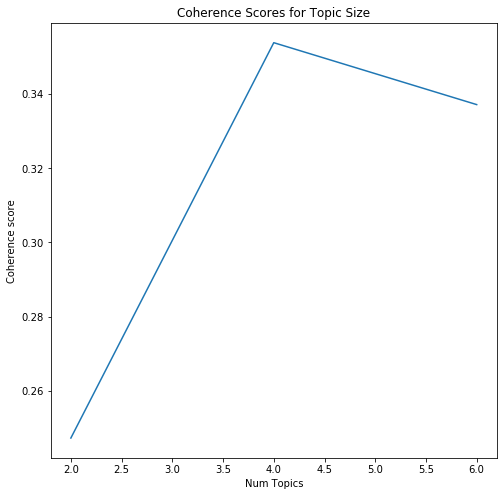

In [205]:
end=8
start=2
step=2

def compute_coherence_values(corpus, dictionary, texts, end, start, step):
   
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, end, step):
    
        # Build LDA model
        lda_model = models.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               random_state=123,
                                               chunksize=100,
                                               passes=500,
                                               per_word_topics=True)
        model_list.append(lda_model)
        
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values
    
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary = id2word, texts=texts, start=start, end=end, step=2)

# Show graph

x = np.arange(start, end, step)
ax = plt.subplots(figsize=(8,8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Coherence Scores for Topic Size')
plt.show()

In [589]:
lda_model = models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=4, 
                                       random_state=123,
                                       chunksize=500,
                                       passes=500,
                                       per_word_topics=True)

In [590]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\users\antonella\desktop\antonella\magistrale\2_anno\tirocinio\nlp\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.155565  0.221640       1        1  32.594784
2     -0.062957  0.105719       2        1  27.478605
3      0.199348 -0.251165       3        1  20.618816
1     -0.291956 -0.076194       4        1  19.307798, topic_info=    Category        Freq        Term       Total  loglift  logprob
166  Default  957.000000      cortez  957.000000  30.0000  30.0000
171  Default  936.000000      ocasio  936.000000  29.0000  29.0000
177  Default  897.000000  alexandria  897.000000  28.0000  28.0000
724  Default  646.000000      strike  646.000000  27.0000  27.0000
30   Default  919.000000         dnc  919.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
139   Topic4  127.360962         job  230.739319   1.0504  -4.8835
322   Topic4  110.470642        part  159.110535   1.2798  -5.0257
209   Topic4  105.208832      matter  161.851700   1.2139  -5.0745
117   Topic4  103.842201       great  161.395172   1.2037  -5.0876
1     Topic4  112.587593       right  597.890381  -0.0250  -5.0067

[191 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
733       4  0.990540      action
177       3  0.998703  alexandria
57        1  0.673646     america
57        2  0.197302     america
57        3  0.104288     america
...     ...       ...         ...
110       2  0.561725        year
110       3  0.193698        year
450       3  0.989733        york
77        1  0.228488     youtube
77        3  0.767973     youtube

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [657]:
pyLDAvis.save_html(LDAvis_prepared, './figures/topics'+ str(number_topics) +'.html')

In [591]:
lda_model.show_topics(num_words=15)

[(0,
  '0.032*"dnc" + 0.028*"trump" + 0.025*"biden" + 0.025*"bernie" + 0.021*"democrat" + 0.018*"berniesanders" + 0.018*"party" + 0.017*"joebiden" + 0.014*"demconvention" + 0.013*"sander" + 0.012*"vote" + 0.012*"second" + 0.011*"convention" + 0.011*"president" + 0.010*"progressive"'),
 (1,
  '0.038*"strike" + 0.019*"boycott" + 0.017*"nba" + 0.017*"work" + 0.017*"player" + 0.017*"word" + 0.012*"point" + 0.011*"medium" + 0.010*"use" + 0.010*"tweet" + 0.009*"blm" + 0.009*"cnn" + 0.009*"worker" + 0.009*"life" + 0.008*"understand"'),
 (2,
  '0.018*"need" + 0.014*"police" + 0.012*"right" + 0.011*"black" + 0.011*"white" + 0.010*"nwsnhc" + 0.010*"time" + 0.010*"berniceking" + 0.010*"care" + 0.008*"sure" + 0.008*"man" + 0.008*"want" + 0.008*"cop" + 0.008*"please" + 0.008*"stop"'),
 (3,
  '0.053*"cortez" + 0.052*"ocasio" + 0.050*"alexandria" + 0.024*"love" + 0.017*"woman" + 0.014*"congress" + 0.012*"new" + 0.011*"puerto" + 0.010*"video" + 0.010*"rep" + 0.009*"state" + 0.009*"congresswoman" + 0.0

In [544]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.clean_text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        original_ind = df.loc[df.clean_text == unique_tweets.loc[i, "text"]].index.values
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([original_ind, int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,[0],2.0,0.8100,"need, right, police, black, white, want, time,...",aoc right poor thing look hunger making
1,"[1, 271, 1452, 2185, 2457, 2721, 3001, 3602, 5...",2.0,0.5624,"need, right, police, black, white, want, time,...",infobit hdmi pin gbps active optical cable ao...
2,[2],3.0,0.6250,"cortez, ocasio, alexandria, love, woman, congr...",aoc love
3,[3],1.0,0.7335,"strike, boycott, nba, word, player, work, poin...",champagne champagnelovers winelovers aoc happ...
4,"[4, 27, 33, 51, 56, 59, 212, 232]",3.0,0.8089,"cortez, ocasio, alexandria, love, woman, congr...",coming ereader near preorder faith christian r...
5,"[5, 11, 3202, 3207, 3220, 3227, 3673, 7432, 87...",0.0,0.4502,"dnc, trump, biden, bernie, democrat, party, jo...",migrantjustice blackagenda fuckice shimby nop...
6,"[6, 12, 3203, 3206, 3221, 3228, 3665, 3666, 36...",0.0,0.3751,"dnc, trump, biden, bernie, democrat, party, jo...",fuckice migrantjustice shimby justiceforchiri...
7,"[7, 10, 3204, 3205, 3222, 3226, 3663, 3667, 36...",0.0,0.6057,"dnc, trump, biden, bernie, democrat, party, jo...",herodavidross miller green mountain veteran p...
8,"[8, 9, 3200, 3201, 3223, 3224, 3664, 3668, 367...",0.0,0.4502,"dnc, trump, biden, bernie, democrat, party, jo...",transgender transidentity trans transequality...
9,[13],0.0,0.6941,"dnc, trump, biden, bernie, democrat, party, jo...",transgender transidentity trans transequality...


In [519]:
topics = [lda_model[corpus[i]] for i in range(len(df.clean_text.dropna().unique()))]
def topics_document_to_dataframe(topics_document, num_topics=4):
    res = pd.DataFrame(columns=range(4))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = pd.concat([topics_document_to_dataframe(topics_document[0], num_topics=4) for topics_document in topics]).reset_index(drop=True).fillna(0)
document_topic.head()


,0,1,2,3
0,0.063102,0.063984,0.810017,0.062898
1,0.062509,0.312610,0.562370,0.062510
2,0.125001,0.125001,0.125001,0.624997
3,0.085885,0.733312,0.093950,0.086853
4,0.063214,0.062507,0.065382,0.808897


In [644]:
# Which document are about topic 1
document_topic.sort_values(3, ascending=False)[3].head(20)
#document_topic.loc[10399]

5441    0.967059
4836    0.965133
4833    0.961380
150     0.958191
4834    0.957916
4875    0.955673
5876    0.955450
5757    0.955404
5328    0.955404
5420    0.955404
4918    0.953854
5191    0.952655
5886    0.952632
5825    0.952632
5649    0.952172
4816    0.951782
5146    0.949922
5453    0.949005
4893    0.949000
5478    0.948617
Name: 3, dtype: float64

In [649]:
print(df.loc[df.clean_text == unique_tweets.loc[4836, "text"], "text"].values[0])


Alexandria Ocasio-Cortez slams ‘proud’ Latina Kimberly Guilfoyle for saying her Puerto Rican mother is an immigrant https://t.co/mcu4IOZ6zZ 
Puerto Rico is part of the United States, but then
Trump didn't even know that, and today the @GOP is whatever Trump is (on that day).


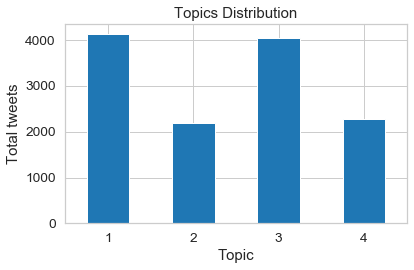

In [656]:
document_topic.idxmax(axis=1).value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)
plt.xlabel("Topic")
plt.ylabel("Total tweets")
plt.xticks(range(4), range(1,5))
plt.title("Topics Distribution")
plt.tight_layout()
plt.savefig("./figures/topic distribution.png")
plt.show()


# Further analysis not included in the report

## Text Classification

In [712]:
hate = pd.DataFrame()
for n in range(1,39):
    data = json.load(open("./data/voc{}.json".format(n)))
    hate = hate.append(pd.DataFrame(data["result"]))

In [745]:
lbl = ['is_about_nationality', 'is_about_ethnicity', 'is_about_religion',
       'is_about_gender', 'is_about_sexual_orientation', 'is_about_disability',
       'is_about_class']

for t in hate.term:
    hate.loc[hate.term == t, "label"] = str([lab.split("_")[-1] for lab in lbl if hate.loc[hate.term == t, lab].values[0] == True])

In [749]:
hate.loc[hate.language=="eng", ["term", 'is_about_nationality', 'is_about_ethnicity', 'is_about_religion',
       'is_about_gender', 'is_about_sexual_orientation', 'is_about_disability',
       'is_about_class']]

,term,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class
59,sandnigger,False,True,False,False,False,False,False
82,Bengali,True,True,True,False,False,False,False
83,rapefugees,False,False,False,False,False,False,True
98,Girl,False,False,False,True,False,False,False
99,whitie,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
19,Charlie,True,True,False,False,False,False,False
20,ho,False,False,False,True,False,False,False
21,hoe,False,False,False,True,False,False,False
22,chief,False,False,False,False,False,False,False


In [1031]:
keywords = list(hate.loc[hate.language=='eng', 'term'].str.lower().dropna().values)
keywords.append("dick")
keywords.append("fuck")
allwords = '|'.join([r"\b" + word + r"\b" for word in keywords])
df.loc[df.text.str.lower().str.contains("dick")].text

2591     @roughdraft2000 It shouldn't be about #JoeBide...
2887     Called aoc ugly and get this. Twitter can suck...
4633     #AOC you are a Howler Monkey.\nA Blabbering Ba...
7300     @KFILE That is right along with why #Kasich go...
8286     #KamalaHarris #MelaniaTrump #AOC #SarahPalin. ...
10491    RT @DickWinchester: @LabourRichard Why has thi...
10497    RT @DickWinchester: @LabourRichard Why has thi...
10515    RT @DickWinchester: @LabourRichard Why has thi...
10527    RT @DickWinchester: @LabourRichard Why has thi...
14337    excuse me mister DJ can I get AOC's dick out o...
14772    @TheBlackCaucus @RepJeffries @AyannaPressley @...
16978    @Moonbea57033181 @AOC You still have a little ...
17328    @slapsdick @Stopdainsanity1 @AOC Poverty cause...
17413    AOC on Fuck’n Brainless Dick Kim Guilfoyle’s ‘...
18796    @michaeldickson @fredman_a I'm sure tlaib, AOC...
21123    @SLEEPERx248 @TheDecemberists @_sweetanger @Co...
21835    @AveryDelta2 @MommyBigDick @OlKaintucky yeah, .

In [1032]:
df["offensive_keywords"] = None
df.loc[df.clean_text.dropna().index, 'offensive_keywords'] = df.clean_text.dropna().str.findall(allwords).apply(set)

In [1033]:
count = Counter([x for b in df.loc[df.offensive_keywords != set()].offensive_keywords.dropna() for x in b])
del count["queen"]
del count["girl"]
del count["eggplant"]
del count["buck"]
del count["property"]
del count["abc"]
del count["frog"]
del count["gay"]
del count["queer"]
del count["shade"]
del count["apple"]
del count["flip"]
del count["skip"]
del count["shine"]


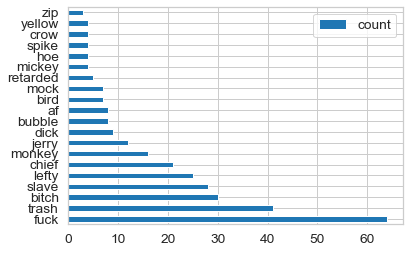

In [1043]:
offense = pd.DataFrame.from_dict(count, orient='index').rename(columns={0:"count"}).sort_values("count", ascending=False)[:20]
offense.plot(kind='barh')


## Graph

In [2172]:
bigram_df = pd.DataFrame.from_dict(dict(scoredList), orient='index').reset_index().rename(columns={0:"value", "index": "bigram"})[:100]

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


trigram_df = pd.DataFrame.from_dict(dict(scoredList_tr), orient='index').reset_index().rename(columns={0:"value", "index": "trigram"})[:10]

# Create dictionary of bigrams and their counts
#d = trigram_df.set_index('trigram').T.to_dict('records')
# Create network plot 
#G3 = nx.Graph()

# Create connections between nodes
#for k, v in d[0].items():
#    print(d[0])
#    G.add_edge(k[0], k[1], weight=(v * 10))
#    G.add_edge(k[1], k[2], weight=(v * 10))


In [2188]:
bigram_df = pd.DataFrame.from_dict(dict(scoredList), orient='index').reset_index().rename(columns={0:"value", "index": "bigram"})

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()
GD = nx.DiGraph()



# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

for k, v in d[0].items():
    GD.add_edge(k[0], k[1])


In [2189]:
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "gon"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "got"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "wan"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "na"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "ta"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "gon"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "got"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "na"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "ta"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "wan"].index, axis=0)

d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()
GD = nx.DiGraph()

for k, v in d[0].items():
    GD.add_edge(k[0], k[1])
    
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


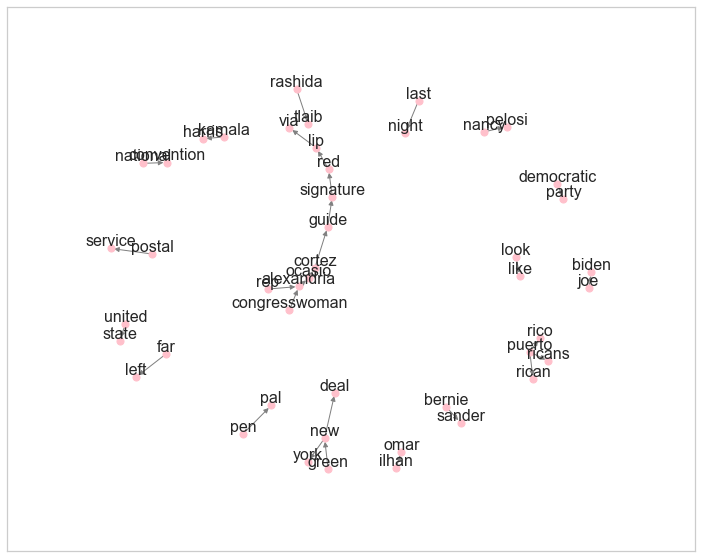

In [2147]:
import math
fig, ax = plt.subplots(figsize=(10, 8))
fixed_positions = {"alexandria":(0,0)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G, k=5) #, fixed=fixed_nodes, pos=fixed_positions)
#pos = nx.centre_layout(G)
edgewidth = [ d['weight']/9000 for (u,v,d) in G.edges(data=True)]

# Plot network
nx.draw_networkx(GD, pos,
                 font_size=15,
                 node_size=50,
                 #width=1,
                 width = 1,
                 edge_color='grey',
                 node_color='pink',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0], value[1]+0.01
    ax.text(x, y,
            s=key,
            #bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=16)


ax.grid(False)
plt.margins(0.15)
plt.tight_layout()
fig.savefig('./figures/net_aoc_three.jpg', transparent=True, bbox_inches="tight")
plt.show()

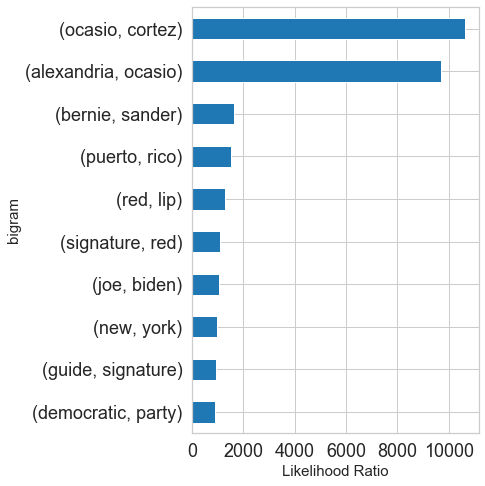

In [2187]:
#trigram_df.set_index("trigram").sort_values("value").plot(kind="barh",  figsize=(9,7), legend=False)
#plt.show()
bigram_df.set_index("bigram").sort_values("value").plot(kind="barh", figsize=(7,7), legend=False, fontsize=18)
plt.xlabel("Likelihood Ratio")
plt.tight_layout()
plt.savefig("./figures/bigrams_hist.png")
plt.show()


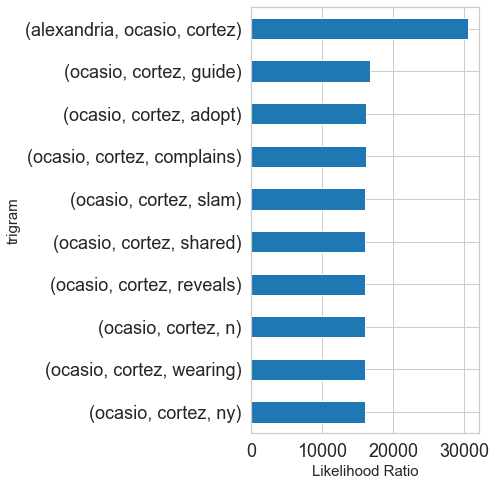

In [2182]:
trigram_df.set_index("trigram").sort_values("value").plot(kind="barh", figsize=(7,7), legend=False, fontsize=18)
plt.xlabel("Likelihood Ratio")
plt.tight_layout()
plt.savefig("./figures/trigrams_hist.png")
plt.show()

## Directed Graph

Questa parte non è stata inclusa nel report.

In [2294]:
print("Number of nodes:", len(GD.nodes),
      "\nNumber of edges:", len(GD.edges),
      "\nAverage Degree:", len(GD.edges)/len(GD.nodes),
      "\nCheck if it is directed:", GD.is_directed(),
     "\nNumber of connected components:",  nx.number_strongly_connected_components(GD))

Number of nodes: 13967 
Number of edges: 109817 
Average Degree: 7.862604711104747 
Check if it is directed: True 
Number of connected components: 44


In [2225]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

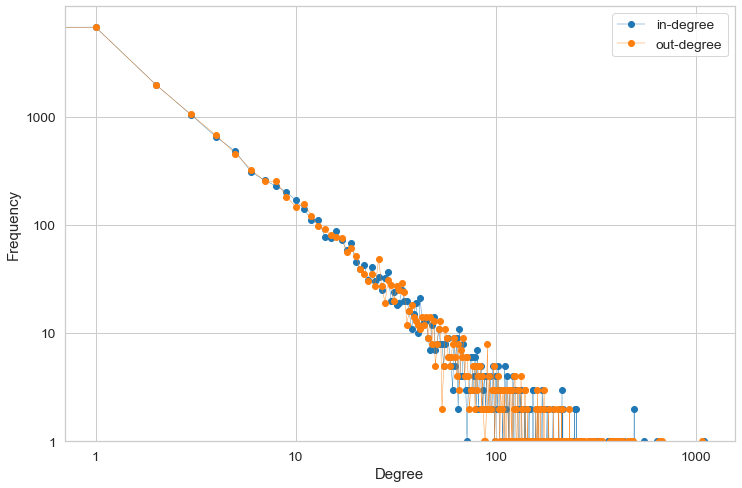

In [2250]:
in_degree_freq = degree_histogram_directed(GD, in_degree=True)
out_degree_freq = degree_histogram_directed(GD, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'o-', label='in-degree', linewidth=0.4) 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'o-', label='out-degree', linewidth=0.4)
plt.xticks([1, 10, 100, 1000], [1,10,100,1000])
plt.yticks([1, 10, 100, 1000], [1,10,100,1000])
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.ylim(1)
plt.show()

In [2269]:
def get_top_keys(dictionary, top):
    items = dictionary.items()
    l = sorted(items, reverse=True, key=lambda x: x[1])
    return l[:10]



In [ ]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(GD, k=1000)
# Closeness centrality
clo_cen = nx.closeness_centrality(GD, k=1000)
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(GD, k=1000)

In [2282]:
get_top_keys(bet_cen,10)

[('aoc', 0.11989583370385172),
 ('like', 0.046036272694011),
 ('people', 0.04564791788973996),
 ('get', 0.0328577833816875),
 ('one', 0.02970402992434143),
 ('u', 0.026499009099362387),
 ('know', 0.02532600915525542),
 ('right', 0.02338667884807183),
 ('trump', 0.022856538718943838),
 ('would', 0.02267784772814105)]